In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

jj = pd.read_csv('jj_translate_1.0.csv')
jj.head()

,Date,Day of Week,Order,Price,Cost
0,2023-01-01,Sunday,Strawberry Joyful,6500,2611.610
1,2023-01-01,Sunday,Kiwi Delight,6500,2264.615
2,2023-01-02,Monday,Seasonal Cup Fruit (9oz),7000,1000.000
3,2023-01-02,Monday,Seasonal Cup Fruit (9oz),7000,1000.000
4,2023-01-02,Monday,Seasonal Cup Fruit (9oz),7000,1000.000


In [3]:
# Step 1: Extract relevant features
# Here, we assume 'Order', 'Price', and 'Cost' are columns in your data
jj['Sales Frequency'] = jj.groupby('Order')['Order'].transform('count')
features = jj[['Price', 'Cost', 'Sales Frequency']]

In [4]:
# Step 2: Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

In [5]:
# Step 3: Apply K-Means Clustering
# Find the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(normalized_features)
    wcss.append(kmeans.inertia_)

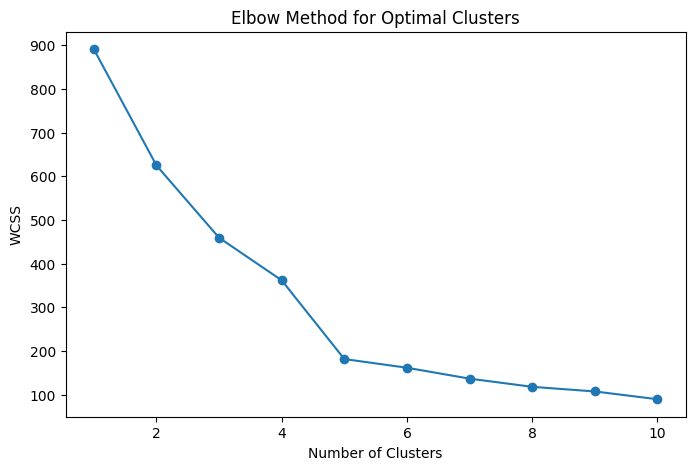

In [6]:
# Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [7]:
optimal_k = 5

# Apply K-Means Clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
jj['Cluster'] = kmeans_optimal.fit_predict(normalized_features)

# Display the cluster assignments
print(jj[['Order', 'Price', 'Cost', 'Sales Frequency', 'Cluster']].head())


                      Order  Price      Cost  Sales Frequency  Cluster
0         Strawberry Joyful   6500  2611.610                7        1
1              Kiwi Delight   6500  2264.615                1        1
2  Seasonal Cup Fruit (9oz)   7000  1000.000                5        2
3  Seasonal Cup Fruit (9oz)   7000  1000.000                5        2
4  Seasonal Cup Fruit (9oz)   7000  1000.000                5        2


In [8]:
# Analyze each cluster to see the characteristics
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Summary:")
    cluster_data = jj[jj['Cluster'] == cluster]
    print(cluster_data[['Order', 'Price', 'Cost', 'Sales Frequency']].describe())


Cluster 0 Summary:
             Price         Cost  Sales Frequency
count   101.000000   101.000000       101.000000
mean   7009.900990  1275.731287        17.693069
std     264.387954   304.810103         3.772910
min    6500.000000  1002.500000        12.000000
25%    7000.000000  1006.500000        15.000000
50%    7000.000000  1274.800000        18.000000
75%    7000.000000  1287.000000        21.000000
max    7500.000000  2192.500000        22.000000

Cluster 1 Summary:
             Price         Cost  Sales Frequency
count    64.000000    64.000000        64.000000
mean   6640.625000  2326.856484         5.531250
std     361.530587   365.651272         2.883829
min    6000.000000  1900.700000         1.000000
25%    6500.000000  2000.000000         2.750000
50%    6500.000000  2310.957500         6.000000
75%    6500.000000  2611.610000         8.000000
max    7500.000000  3270.000000         9.000000

Cluster 2 Summary:
             Price         Cost  Sales Frequency
count   1

In [9]:
from sklearn.linear_model import LinearRegression

# Prepare to build a model for each cluster
pricing_models = {}

# Iterate over each cluster and build a model
for cluster in range(optimal_k):
    cluster_data = jj[jj['Cluster'] == cluster]
    
    # Define features and target
    X = cluster_data[['Cost', 'Sales Frequency']].values  # Use relevant features
    y = cluster_data['Price'].values
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the model
    pricing_models[cluster] = model
    print(f"Model for Cluster {cluster} trained.")

Model for Cluster 0 trained.
Model for Cluster 1 trained.
Model for Cluster 2 trained.
Model for Cluster 3 trained.
Model for Cluster 4 trained.


In [10]:
# Predict optimal prices for each cluster
for cluster in range(optimal_k):
    cluster_data = jj[jj['Cluster'] == cluster]
    model = pricing_models[cluster]
    
    # Predict the price using the model
    cluster_data['Predicted Price'] = model.predict(cluster_data[['Cost', 'Sales Frequency']].values)
    
    # Display the predicted prices
    print(f"\nPredicted Prices for Cluster {cluster}:")
    print(cluster_data[['Order', 'Cost', 'Sales Frequency', 'Predicted Price']].head())


Predicted Prices for Cluster 0:
                            Order     Cost  Sales Frequency  Predicted Price
5                Apple Kale Juice  1006.50               22      7096.505422
12  Apple Lemon Kale Celery Juice  1853.50               18      6882.501528
13                   Orange Juice  1287.00               13      6978.653213
16                     Pear Juice  1002.50               15      7054.553322
20             Apple Carrot Juice  1205.38               12      6990.795016

Predicted Prices for Cluster 1:
                      Order      Cost  Sales Frequency  Predicted Price
0         Strawberry Joyful  2611.610                7      6599.271153
1              Kiwi Delight  2264.615                1      6918.420430
6    Green Grape Kale Juice  2611.500                2      6918.422967
10  Strawberry Greek Yogurt  2000.000                1      6869.723560
11  Strawberry Lemon Breeze  2838.930                8      6577.270245

Predicted Prices for Cluster 2:
       

/var/folders/hm/xnw5nd2n1yl25z8xd614c56w0000gn/T/ipykernel_83723/1533682114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Predicted Price'] = model.predict(cluster_data[['Cost', 'Sales Frequency']].values)
/var/folders/hm/xnw5nd2n1yl25z8xd614c56w0000gn/T/ipykernel_83723/1533682114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Predicted Price'] = model.predict(cluster_data[['Cost', 'Sales Frequency']].values)
/var/folders/hm/xnw5nd2n1yl25z8xd614c56w0000gn/T/ipykernel_8